In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
import allan_variance
import pandas as pd
from calibration import IntrinsicCalibration
from scipy.spatial.transform import Rotation as R
from scipy.linalg import null_space


/home/su/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [3]:
def cross_dot(b):
    # d(axb)/d(a)
    cross_dot = np.array([[0, b[2], -b[1]],
                    [-b[2], 0, b[0]],
                    [b[1], -b[0], 0]])
    return cross_dot

def cross2_dot(a, b):
    #d(ax(axb))/d(a)
    cross2_dot = np.array([[a[1]*b[1]+a[2]*b[2], a[0]*b[1]-2*a[1]*b[0], a[0]*b[2]-2*a[2]*b[0]],
                           [-2*a[0]*b[1]+a[1]*b[0], a[0]*b[0]+a[2]*b[2], a[1]*b[2]-2*a[2]*b[1]],
                           [-2*a[0]*b[2]+a[2]*b[0], -2*a[1]*b[2]+a[2]*b[1], a[0]*b[0]+a[1]*b[1]]])
    return cross2_dot
def wedge(a):
    Ahat = np.array([[0, -a[2], a[1]],
                    [a[2], 0, -a[0]],
                    [-a[1], a[0], 0]])
    return Ahat

In [4]:
def dynamics(dt, state, RW, w_input_noise):
    state_next = np.zeros(9) 
    state_next[0:3] = state[0:3] + state[3:6] * dt + RW[3:6] * np.random.randn(3)    # omega
    state_next[3:6] = w_input_noise * np.random.randn(3)                             # omega_dot
    state_next[6:9] = state[6:9] + RW[0:3] * np.random.randn(3)                      # specific force
    return state_next

def dynamics_est(dt, state):
    state_next = np.zeros(9)
    state_next[0:3] = state[0:3] + state[3:6] * dt          # omega
    state_next[3:6] = np.zeros(3)                           # omega_dot
    state_next[6:9] = state[6:9]                            # specific force
    return state_next

def Jacobian_f(dt):
    F = np.zeros((9, 9))
    F[0:3, 0:3]            = np.eye(3)
    F[0:3, 3:6]            = dt * np.eye(3)
    return F

In [5]:
def measurement(state, pos_r, Rb_si, WN, num_imus):
    meas = np.zeros(6*num_imus)
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        s_i = Rb_si_sub @ (sf + wedge(omega) @ wedge(omega) @ r_sub + wedge(omega_dot) @ r_sub + WN[i*num_imus:3+i*num_imus]*np.random.randn(3))
        omega_i = Rb_si_sub @ omega + WN[3+i*num_imus:6+i*num_imus]*np.random.randn(3)
        meas[i*6:6+i*6] = np.concatenate((s_i, omega_i))
    return meas


def measurement_est(state, pos_r, Rb_si, num_imus):
    meas = np.zeros(6*num_imus)
    H = np.zeros((6*num_imus, 9))
    for i in range(num_imus):
        Rb_si_sub = Rb_si[i]
        r_sub = pos_r[i]
        sf = state[6:9]
        omega = state[0:3]
        omega_dot = state[3:6]
        H_i = np.zeros((6, 9))
        H_i[0:3, 0:3] = Rb_si_sub @ cross2_dot(omega, r_sub)
        H_i[0:3, 3:6] = Rb_si_sub @ cross_dot(r_sub)
        H_i[0:3, 6:9] = Rb_si_sub
        H_i[3:6, 0:3] = Rb_si_sub
        meas[i*6:6+i*6] = H_i @ state
        H[i*6:6+i*6, :] = H_i
    return meas, H

In [ ]:
# def left_nullspace_projection(A):
#     A_transpose = A.T
#     nullspace_basis = null_space(A_transpose)
#     projection_matrix = nullspace_basis @ nullspace_basis.T
#     return projection_matrix

# def compute_virtual_imu(omega_A, omega_B, a_A, a_B, ARV, BRV, VpA, VpB):
#     """
#     Compute virtual IMU measurements (gyroscope and accelerometer) from two IMUs.
    
#     Parameters:
#         omega_A, omega_B: Angular velocities from IMU A and B
#         a_A, a_B: Accelerations from IMU A and B
#         ARV, BRV: Rotation matrices from virtual frame V to IMU frames A and B
#         VpA, VpB: Positions of IMU A and B in the virtual IMU frame
#         sigma_g: Gyroscope noise standard deviation
    
#     Returns:
#         omega_V: Virtual gyroscope measurement
#         a_V: Virtual accelerometer measurement
#     """
#     # Define matrices as per the equations in the paper
#     N = np.vstack((ARV, BRV))
#     Y = np.vstack((ARV @ skew_matrix(VpA), BRV @ skew_matrix(VpB)))
#     print(Y)
#     ZT = left_nullspace_projection(Y)
    
#     # Calculate virtual gyroscope measurement (Equation 21)
#     omega_m = np.hstack((omega_A, omega_B))

#     omega_V = np.linalg.pinv(N) @ omega_m
#     # Calculate virtual accelerometer measurement (Equation 34)
#     a_m = np.hstack((a_A, a_B))
#     S_omega_V = np.hstack((ARV @ np.dot(skew_matrix(omega_V), skew_matrix(omega_V)) @ VpA, 
#                           BRV @ np.dot(skew_matrix(omega_V), skew_matrix(omega_V)) @ VpB))
#     print(S_omega_V)
#     # S_omega_V = np.vstack((ARV @ skew_matrix(VpA), BRV @ skew_matrix(VpB))) @ omega_V
#     T = np.linalg.pinv(ZT @ N) @ ZT
#     a_V = T @ (a_m - S_omega_V)
    
#     return omega_V, a_V

# def skew_matrix(v):
#     return np.array([[0, -v[2], v[1]],
#                      [v[2], 0, -v[0]],
#                      [-v[1], v[0], 0]])


In [17]:
def left_nullspace_projection(A):
    A_transpose = A.T
    nullspace_basis = null_space(A_transpose)
    projection_matrix = nullspace_basis @ nullspace_basis.T
    return projection_matrix

def compute_virtual_imu(meas, rotations, positions, num_imu):
    """
    Compute virtual IMU measurements (gyroscope and accelerometer) from two IMUs.
    
    Parameters:
        omega_A, omega_B: Angular velocities from IMU A and B
        a_A, a_B: Accelerations from IMU A and B
        ARV, BRV: Rotation matrices from virtual frame V to IMU frames A and B
        VpA, VpB: Positions of IMU A and B in the virtual IMU frame
        sigma_g: Gyroscope noise standard deviation
    
    Returns:
        omega_V: Virtual gyroscope measurement
        a_V: Virtual accelerometer measurement
    """
    # Define matrices as per the equations in the paper
    N = np.vstack(rotations)
    Y = []
    omeag_m = []
    a_m = []
    S_omega_V = []
    for i in range(num_imu):
        Y.append(rotations[i] @ skew_matrix(positions[i]))
        omeag_m.append(meas[i*6+3:i*6+6])
        a_m.append(meas[i*6:i*6+3])
    omega_m = np.hstack(omeag_m)
    a_m = np.hstack(a_m)
    Y = np.vstack(Y)
    ZT = left_nullspace_projection(Y)
    omega_V = np.linalg.pinv(N) @ omega_m

    for i in range(num_imu):
        S_omega_V.append(rotations[i] @ np.dot(skew_matrix(omega_V), skew_matrix(omega_V)) @ positions[i])
    S_omega_V = np.hstack(S_omega_V)
    T = np.linalg.pinv(ZT @ N) @ ZT
    a_V = T @ (a_m - S_omega_V)
    
    return omega_V, a_V

def skew_matrix(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])



MagPIE Dataset

In [9]:
def interpolate_df(df_base, df_target, columns):
    df_interp = pd.DataFrame({'t': df_base['t']})
    for col in columns:
        df_interp[col] = np.interp(df_base['t'], df_target['t'], df_target[col])
    return df_interp

In [10]:
num_imus = 5

IMU1_path = 'dataset/static/magpie2Dataset_StaticData_imu1.csv'
IMU2_path = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_path = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_path = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_path = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'


df1 = pd.read_csv(IMU1_path)
df2 = pd.read_csv(IMU2_path)
df3 = pd.read_csv(IMU3_path)
df4 = pd.read_csv(IMU4_path)
df5 = pd.read_csv(IMU5_path)

columns = ['gx', 'gy', 'gz', 'ax', 'ay', 'az']
df2_interp = interpolate_df(df1, df2, columns)
df3_interp = interpolate_df(df1, df3, columns)
df4_interp = interpolate_df(df1, df4, columns)
df5_interp = interpolate_df(df1, df5, columns)
dfs = [df1, df2_interp, df3_interp, df4_interp, df5_interp]
# dfs = [df1, df2, df3, df4, df5]

t_data = {}
gx_data, gy_data, gz_data = {}, {}, {}
ax_data, ay_data, az_data = {}, {}, {}
measurements = []

for i, df in enumerate(dfs, start=1):
    t_data[f'df{i}_t'] = np.array((df['t']-df['t'][0])/1e9)
    gx_data[f'df{i}_gx'] = np.array(df['gx'])
    gy_data[f'df{i}_gy'] = np.array(df['gy'])
    gz_data[f'df{i}_gz'] = np.array(df['gz'])
    ax_data[f'df{i}_ax'] = np.array(df['ax'])
    ay_data[f'df{i}_ay'] = np.array(df['ay'])
    az_data[f'df{i}_az'] = np.array(df['az'])

for i in range(len(df1)):
# for i in range(4000):
    measurements.append([ax_data['df1_ax'][i], ay_data['df1_ay'][i], az_data['df1_az'][i], gx_data['df1_gx'][i], gy_data['df1_gy'][i], gz_data['df1_gz'][i], 
                        ax_data['df2_ax'][i], ay_data['df2_ay'][i], az_data['df2_az'][i], gx_data['df2_gx'][i], gy_data['df2_gy'][i], gz_data['df2_gz'][i],
                        ax_data['df3_ax'][i], ay_data['df3_ay'][i], az_data['df3_az'][i], gx_data['df3_gx'][i], gy_data['df3_gy'][i], gz_data['df3_gz'][i],
                        ax_data['df4_ax'][i], ay_data['df4_ay'][i], az_data['df4_az'][i], gx_data['df4_gx'][i], gy_data['df4_gy'][i], gz_data['df4_gz'][i],
                        ax_data['df5_ax'][i], ay_data['df5_ay'][i], az_data['df5_az'][i], gx_data['df5_gx'][i], gy_data['df5_gy'][i], gz_data['df5_gz'][i]])
    
measurements = np.array(measurements)

dt = np.mean(np.diff(t_data['df1_t']))

The parameters of individiual sensors that are estimated from calibration

In [11]:
def calibrated_measurements(meas, det_params, biases, R_acc, R_gyro): 
    gravity = 9.81
    cal_meas = []
    for i in range(len(meas)):
        all_meas = []
        for j in range(num_imus):
            raw_a = meas[i][j*6:j*6+3]
            raw_g = meas[i][j*6+3:j*6+6]
            b_a = [biases['ax'][f'df{j+1}_ax'], biases['ay'][f'df{j+1}_ay'], biases['az'][f'df{j+1}_az']]
            b_g = [biases['gx'][f'df{j+1}_gx'], biases['gy'][f'df{j+1}_gy'], biases['gz'][f'df{j+1}_gz']]
            SM_a = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            SM_g = np.linalg.inv(det_params['acc_M'][f'imu{j+1}'])
            A = det_params['A'][f'imu{j+1}']
            a_si = raw_a - b_a
            a_si[2] -= gravity
            a_si = np.dot(SM_a, a_si)
            g_si = np.dot(SM_g, (raw_g - b_g - np.dot(A, a_si)))

            # # Transform from frame si to frame b
            # R_a = R_acc[j]
            # R_g = R_gyro[j]
            # a_b = R_a @ a_si
            # g_b = R_g @ g_si

            new_meas = np.array([a_si, g_si]).flatten()
            all_meas.append(new_meas)
        flattened_meas = np.array(all_meas).flatten()
        cal_meas.append(flattened_meas)
    
    return cal_meas

IMU1_cal = 'dataset/static/magpie2Dataset_StaticData_imu1.csv'
IMU2_cal = 'dataset/static/magpie2Dataset_StaticData_imu2.csv'
IMU3_cal = 'dataset/static/magpie2Dataset_StaticData_imu3.csv'
IMU4_cal = 'dataset/static/magpie2Dataset_StaticData_imu4.csv'
IMU5_cal = 'dataset/static/magpie2Dataset_StaticData_imu5.csv'
IMU_paths = [IMU1_cal, IMU2_cal, IMU3_cal, IMU4_cal, IMU5_cal]
cal_path = 'dataset/static/magpie2Dataset_000-imu.yaml'
cal = IntrinsicCalibration(IMU_paths, cal_path)
cal.get_av_params()
cal.get_bias()
cal.get_det_params()
params = cal.params
biases = cal.biases
det_params = cal.det_params


T01 = np.array(det_params['T_i_b']['imu1'])
T02 = np.array(det_params['T_i_b']['imu2'])
T03 = np.array(det_params['T_i_b']['imu3'])
T04 = np.array(det_params['T_i_b']['imu4'])
T05 = np.array(det_params['T_i_b']['imu5'])

R21 = T02[:3,:3].T.dot(T01[:3,:3])
R31 = T03[:3,:3].T.dot(T01[:3,:3])
R41 = T04[:3,:3].T.dot(T01[:3,:3])
R51 = T05[:3,:3].T.dot(T01[:3,:3])
R_acc = [np.eye(3), R21.T, R31.T, R41.T, R51.T]

P21 = -T02[:3,3] + T01[:3,3]
P31 = -T03[:3,3] + T01[:3,3]
P41 = -T04[:3,3] + T01[:3,3]
P51 = -T05[:3,3] + T01[:3,3]

C01 = np.array(det_params['C_gyro_i']['imu1'])
C02 = np.array(det_params['C_gyro_i']['imu2'])
C03 = np.array(det_params['C_gyro_i']['imu3'])
C04 = np.array(det_params['C_gyro_i']['imu4'])
C05 = np.array(det_params['C_gyro_i']['imu5'])

C21 = C02.T.dot(C01)
C31 = C03.T.dot(C01)
C41 = C04.T.dot(C01)
C51 = C05.T.dot(C01)
R_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]


cal_meas = calibrated_measurements(measurements, det_params, biases, R_acc, R_gyro)
cal_meas = np.array(cal_meas)

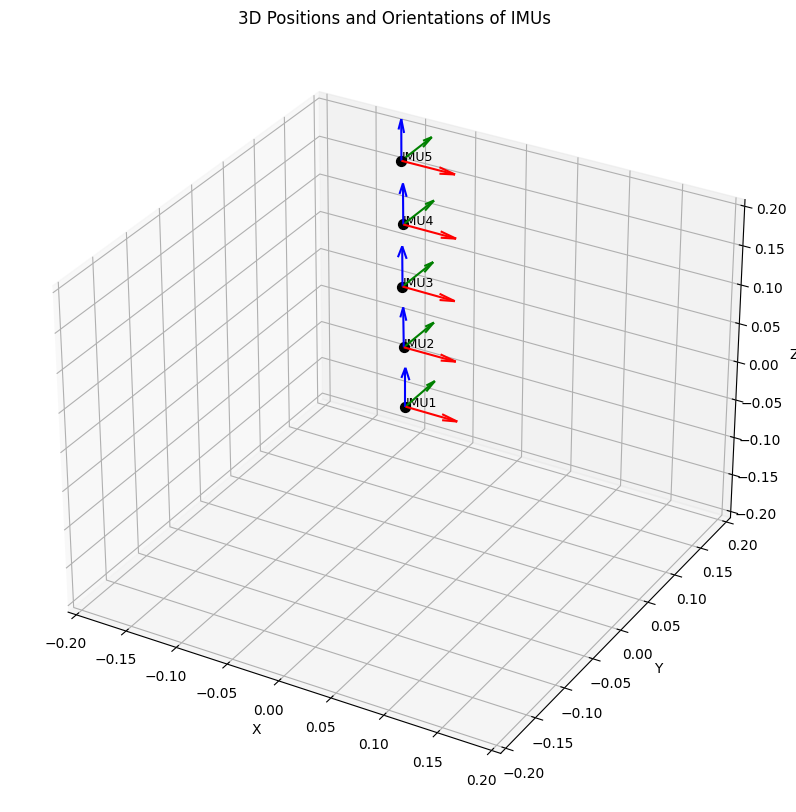

In [12]:
positions = [np.array([0, 0, 0]), -P21, -P31, -P41, -P51]

rotations = [np.eye(3), R21.T, R31.T, R41.T, R51.T]
rotations_gyro = [np.eye(3), C21.T, C31.T, C41.T, C51.T]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
axis_colors = ['r', 'g', 'b']
labels = ['IMU1', 'IMU2', 'IMU3', 'IMU4', 'IMU5']

for i, (pos, rot) in enumerate(zip(positions, rotations_gyro)):
    ax.scatter(pos[0], pos[1], pos[2], color='k', s=50)
    ax.text(pos[0], pos[1], pos[2], labels[i], fontsize=9)
    for j in range(3):
        axis = rot[:, j]
        ax.quiver(pos[0], pos[1], pos[2], axis[0], axis[1], axis[2], length=0.05, color=axis_colors[j])

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.2)
ax.set_title('3D Positions and Orientations of IMUs')

plt.show()

In [13]:
df_WN = []
df_RW = []
for i in range(1, len(IMU_paths)+1):
    for imu in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
        df_WN.append(params['wn'][f'df{i}_{imu}'])
        df_RW.append(params['rw'][f'df{i}_{imu}'])

In [14]:
WN_a = []
WN_w = []
RW_a = []
RW_w = []
for i in range(num_imus):
    WN_a.append(df_WN[i*6:3+i*6])
    WN_w.append(df_WN[3+i*6:6+i*6])
    RW_a.append(df_RW[i*6:3+i*6])
    RW_w.append(df_RW[3+i*6:6+i*6])
print(np.mean(WN_a))
print(np.mean(WN_w))
print(np.mean(RW_a))
print(np.mean(RW_w))

0.0006215722818142166
5.0025280273232116e-05
1.850221801685592e-05
1.091078078122994e-06


In [18]:
w_input_noise = 1e-3

Rb_si = [np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)]
pos_r = [np.array([0, 0, 0]), P21, P31, P41, P51]
time = t_data['df1_t']

WN_STD = np.array(df_WN)
RW_STD = np.array([np.mean(df_RW[i::6]) for i in range(6)])

# state: omega, alpha, accel, 6 x number_of_imus (RW)
state = np.zeros(9)
state_est = np.zeros(9)

# initial_mean = [np.mean(cal_meas[0,i::6]) for i in range(6)]
# omega = np.array(initial_mean[3:6])
omega_dot = np.array([0, 0, 0])
# sf = np.array(initial_mean[0:3])
omega = np.array([0, 0, 0])
sf = np.array([0, 0, 0])
state_est[0:3] = omega
state_est[6:9] = sf
state[0:3] = omega
state[6:9] = sf
state_hist = np.zeros((len(time), 9))
state_est_hist = np.zeros((len(time), 9))
meas = np.zeros(6*num_imus)
meas_hist = np.zeros((len(time),6*num_imus))

# Initial state Coveriance
P_est = np.eye(9)

# Covariance of process noise covariance
Q = np.zeros((9, 9))
Q[0:3,0:3] = np.diag(RW_STD[3:6] ** 2)
Q[3:6,3:6] = w_input_noise ** 2 * np.eye(3)
Q[6:9,6:9] = np.diag(RW_STD[0:3] ** 2)

# Covariance of measurement noise covariance
R = np.diag(WN_STD**2)
omega_V_hist = np.zeros((len(time), 3))
a_V_hist = np.zeros((len(time), 3))

for i in trange(len(time)):
    omega_V, a_V = compute_virtual_imu(cal_meas[i], rotations, positions, num_imus)
    omega_V_hist[i] = omega_V
    a_V_hist[i] = a_V
    state = dynamics(dt, state, RW_STD, w_input_noise)
    state_hist[i] = state
    # Prediction step
    state_pred = dynamics_est(dt, state_est)
    F = Jacobian_f(dt)
    P_pred = np.dot(np.dot(F, P_est), F.T) + Q

    # Update step
    meas, H = measurement_est(state_pred, pos_r, Rb_si, num_imus)
    y = cal_meas[i] - meas
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))
    state_est = state_pred + np.dot(K, y)
    P_est = np.dot(np.eye(len(P_est))- np.dot(K,H), P_pred)
    meas_hist[i] = meas
    state_est_hist[i] = state_est

# csv_write(state_est_hist, filename)

  0%|          | 0/380058 [00:00<?, ?it/s]

100%|██████████| 380058/380058 [07:48<00:00, 810.55it/s] 


Text(0.5, 0, 'Time (s)')

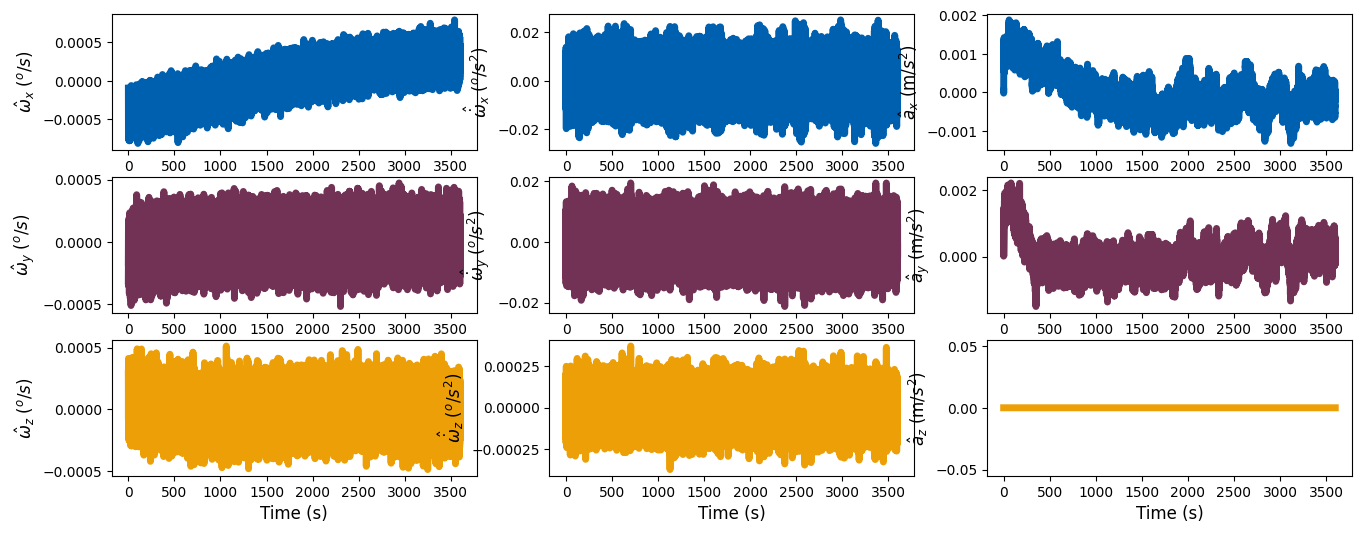

In [19]:
fig2, ax2 = plt.subplots(3, 3, figsize = (16, 6))
ax2[0,0].plot(time, state_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, state_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, state_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$\hat{\omega}_x$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$\hat{\omega}_y$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$\hat{\omega}_z$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, state_est_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, state_est_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, state_est_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\hat{\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\hat{\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\hat{\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

ax2[0,2].plot(time, state_est_hist[:,6], linewidth=5, color = "#0060B0", label = "$\hat{SF}_x$")
ax2[1,2].plot(time, state_est_hist[:,7], linewidth=5, color = "#723255", label = "$\hat{SF}_y$")
ax2[2,2].plot(time, state_est_hist[:,8], linewidth=5, color = "#EC9F06", label = "$\hat{SF}_z$")
ax2[0,2].set_ylabel("$\hat{a}_x$ (m/$s^2$)", fontsize=12)
ax2[1,2].set_ylabel("$\hat{a}_y$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_ylabel("$\hat{a}_z$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

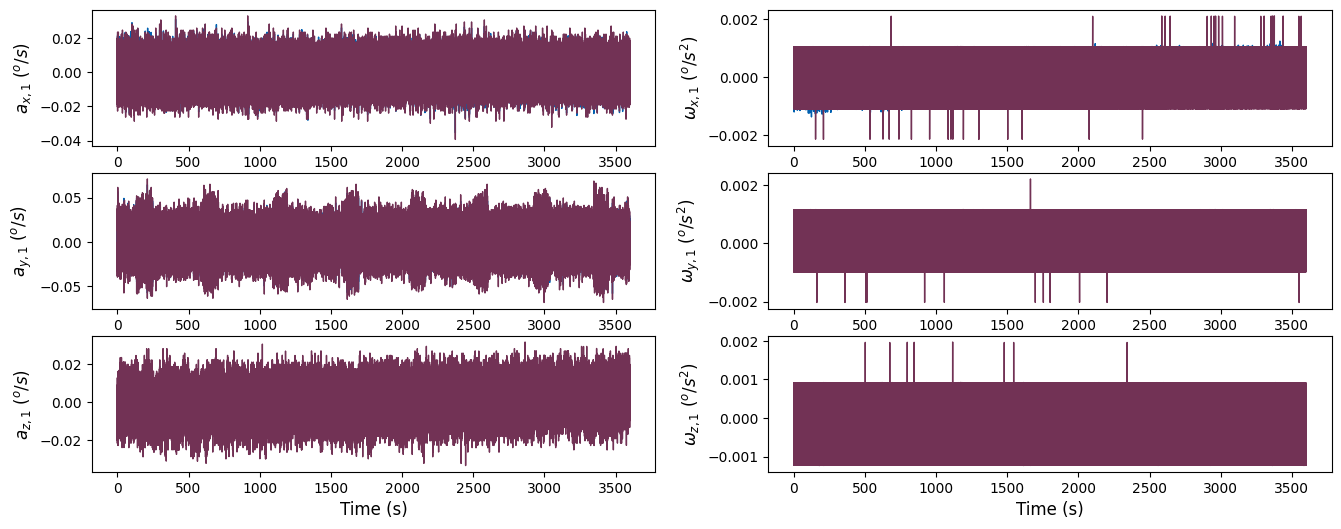

In [21]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, a_V_hist[:,0], linewidth=1, color = "#0060B0")
ax2[0,0].plot(time, cal_meas[:,0], linewidth=1, color = "#723255")
ax2[1,0].plot(time, a_V_hist[:,1], linewidth=1, color = "#0060B0")
ax2[1,0].plot(time, cal_meas[:,1], linewidth=1, color = "#723255")
ax2[2,0].plot(time, a_V_hist[:,2], linewidth=1, color = "#0060B0")
ax2[2,0].plot(time, cal_meas[:,2], linewidth=1, color = "#723255")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, omega_V_hist[:,0], linewidth=1, color = "#0060B0")
ax2[0,1].plot(time,     cal_meas[:,3], linewidth=1, color = "#723255")
ax2[1,1].plot(time, omega_V_hist[:,1], linewidth=1, color = "#0060B0")
ax2[1,1].plot(time,     cal_meas[:,4], linewidth=1, color = "#723255")
ax2[2,1].plot(time, omega_V_hist[:,2], linewidth=1, color = "#0060B0")
ax2[2,1].plot(time,     cal_meas[:,5], linewidth=1, color = "#723255")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

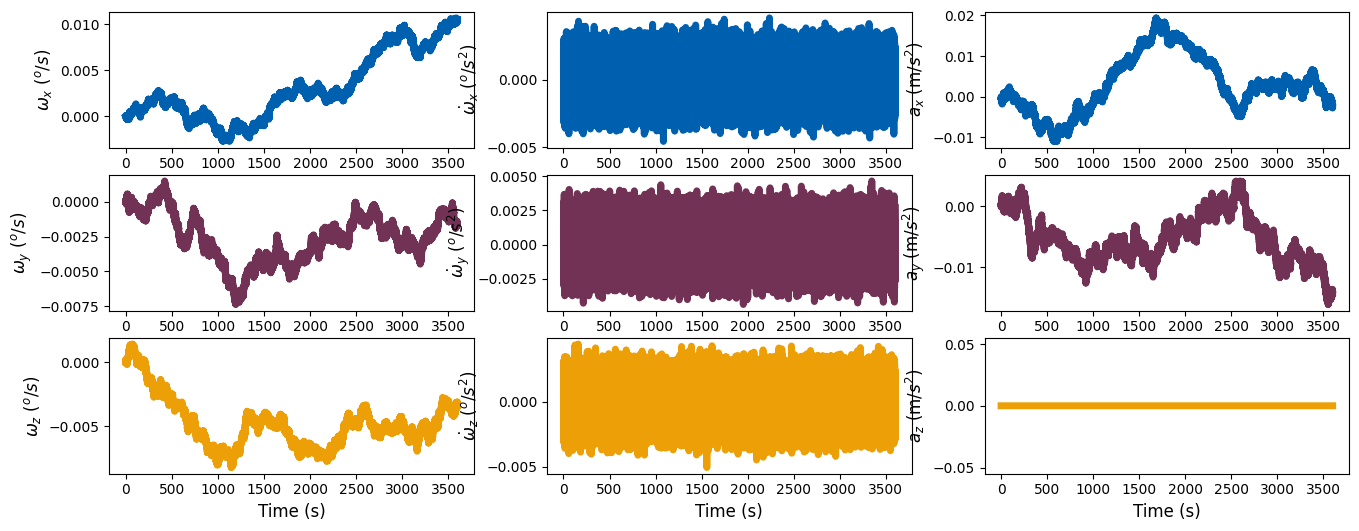

In [22]:
fig2, ax2 = plt.subplots(3, 3, figsize = (16, 6))
ax2[0,0].plot(time, state_hist[:,0], linewidth=5, color = "#0060B0", label = "${\omega}_x$")
ax2[1,0].plot(time, state_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_y$")
ax2[2,0].plot(time, state_hist[:,2], linewidth=5, color = "#EC9F06", label = "${\omega}_z$")
ax2[0,0].set_ylabel("${\omega}_x$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("${\omega}_y$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("${\omega}_z$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, state_hist[:,3], linewidth=5, color = "#0060B0", label = "${\dot{\omega}}_x$")
ax2[1,1].plot(time, state_hist[:,4], linewidth=5, color = "#723255", label = "${\dot{\omega}}_y$")
ax2[2,1].plot(time, state_hist[:,5], linewidth=5, color = "#EC9F06", label = "${\dot{\omega}}_z$")
ax2[0,1].set_ylabel("${\dot{\omega}}_x$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("${\dot{\omega}}_y$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("${\dot{\omega}}_z$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

ax2[0,2].plot(time, state_hist[:,6], linewidth=5, color = "#0060B0", label = "$a_x$")
ax2[1,2].plot(time, state_hist[:,7], linewidth=5, color = "#723255", label = "$a_y$")
ax2[2,2].plot(time, state_hist[:,8], linewidth=5, color = "#EC9F06", label = "$a_z$")
ax2[0,2].set_ylabel("${a}_x$ (m/$s^2$)", fontsize=12)
ax2[1,2].set_ylabel("${a}_y$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_ylabel("${a}_z$ (m/$s^2$)", fontsize=12)
ax2[2,2].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

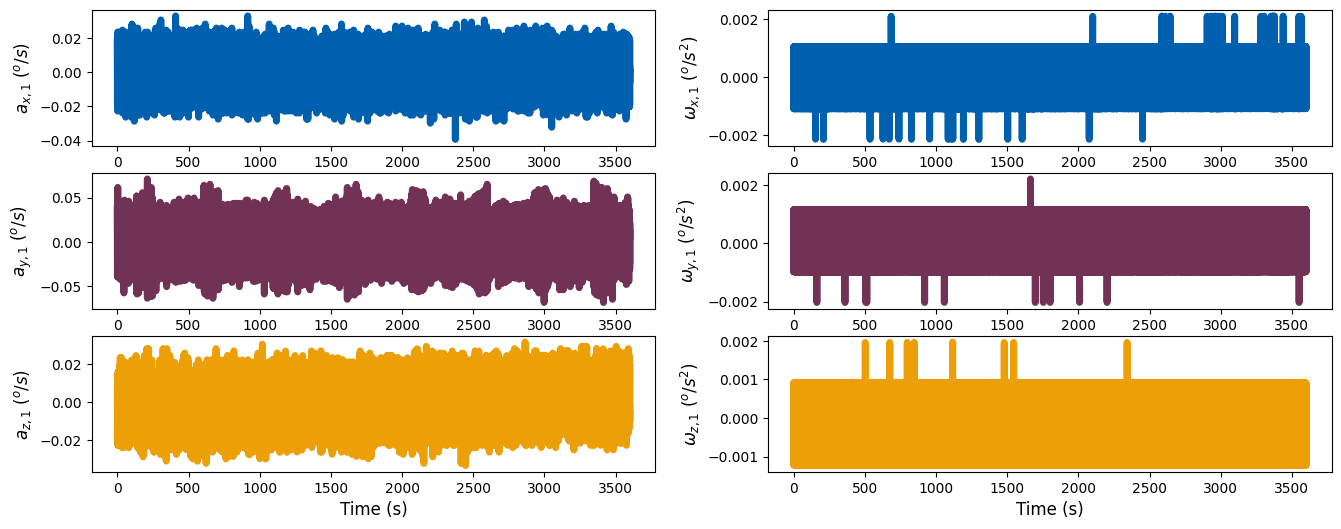

In [23]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, cal_meas[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, cal_meas[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, cal_meas[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, cal_meas[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, cal_meas[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, cal_meas[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Text(0.5, 0, 'Time (s)')

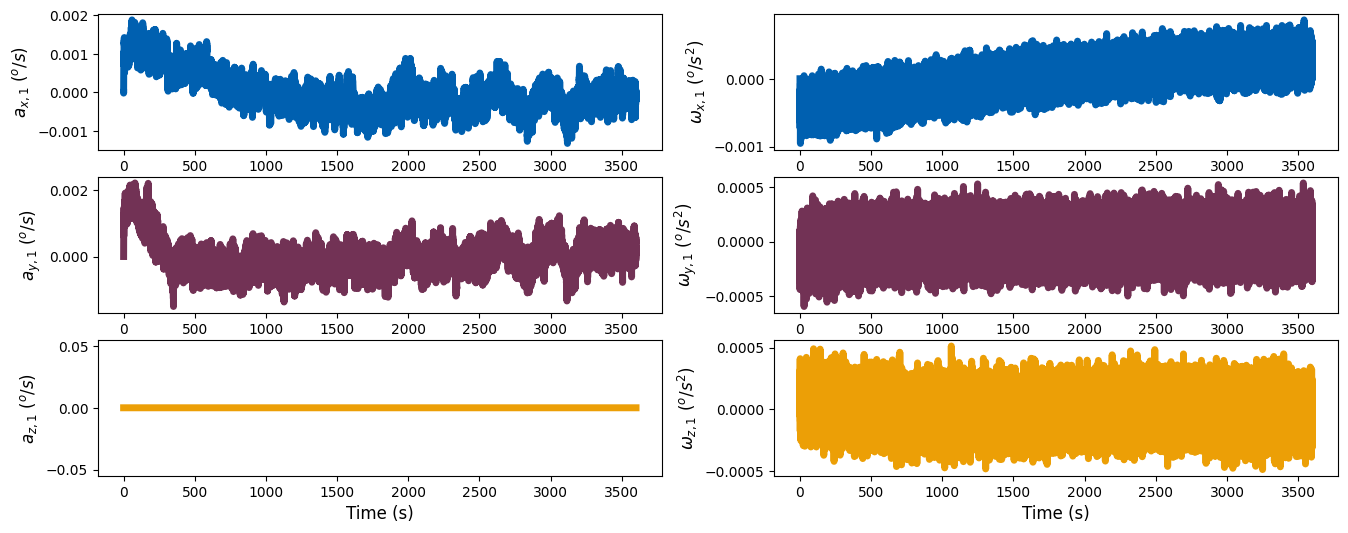

In [24]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time, meas_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[1,0].plot(time, meas_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{\omega}_y$")
ax2[2,0].plot(time, meas_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{\omega}_z$")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, meas_hist[:,3], linewidth=5, color = "#0060B0", label = "$\hat{\dot{\omega}}_x$")
ax2[1,1].plot(time, meas_hist[:,4], linewidth=5, color = "#723255", label = "$\hat{\dot{\omega}}_y$")
ax2[2,1].plot(time, meas_hist[:,5], linewidth=5, color = "#EC9F06", label = "$\hat{\dot{\omega}}_z$")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

Inertial Navigation (in progress)

In [75]:
import numpy as np
from scipy.spatial.transform import Rotation as R

class VirtualIMUPropagation:
    def __init__(self, initial_position, initial_velocity, initial_orientation, gyro_bias, accel_bias):
        self.position = initial_position      # Position vector in global frame
        self.velocity = initial_velocity      # Velocity vector in global frame
        self.orientation = R.from_quat(initial_orientation)  # Orientation quaternion
        self.gyro_bias = gyro_bias            # Gyroscope bias vector
        self.accel_bias = accel_bias          # Accelerometer bias vector

    def propagate(self, gyro_measurement, accel_measurement, dt):
        """
        Propagate the virtual IMU state using gyroscope and accelerometer measurements.

        Parameters:
        - gyro_measurement: Gyroscope data (angular velocity in rad/s)
        - accel_measurement: Accelerometer data (linear acceleration in m/s^2)
        - dt: Time step for propagation in seconds
        """
        # 1. Correct the gyroscope and accelerometer readings for biases
        gyro_corrected = gyro_measurement - self.gyro_bias
        accel_corrected = accel_measurement - self.accel_bias

        # 2. Update orientation (using gyroscope data)
        delta_rotation = R.from_rotvec(gyro_corrected * dt)  # Small rotation vector
        self.orientation = self.orientation * delta_rotation  # Update orientation

        # 3. Rotate acceleration to the global frame
        accel_global = self.orientation.apply(accel_corrected)

        # 4. Update velocity (integrate acceleration in global frame)
        self.velocity += accel_global * dt

        # 5. Update position (integrate velocity in global frame)
        self.position += self.velocity * dt

        return {
            "position": self.position,
            "velocity": self.velocity,
            "orientation": self.orientation.as_quat(),
            "gyro_bias": self.gyro_bias,
            "accel_bias": self.accel_bias
        }

# Initialize the virtual IMU propagation with initial states
initial_position = np.array([0, 0, 0])
initial_velocity = np.array([0, 0, 0])
initial_orientation = [1, 0, 0, 0]  # Quaternion (w, x, y, z)
gyro_bias = np.array([0.01, 0.02, 0.015])  # Initial gyroscope bias
accel_bias = np.array([0.1, -0.1, 0.05])   # Initial accelerometer bias

# Instantiate the VirtualIMUPropagation class
virtual_imu = VirtualIMUPropagation(initial_position, initial_velocity, initial_orientation, gyro_bias, accel_bias)

# Example sensor data for propagation
gyro_data = np.array([0.02, 0.01, 0.015])     # Gyroscope measurement (rad/s)
accel_data = np.array([0, 0, -9.81])          # Accelerometer measurement (m/s^2)
dt = 0.01                                     # Time step (seconds)

# Perform propagation
updated_state = virtual_imu.propagate(gyro_data, accel_data, dt)

print("Updated Virtual IMU State:")
print("Position:", updated_state["position"])
print("Velocity:", updated_state["velocity"])
print("Orientation (Quaternion):", updated_state["orientation"])
print("Gyro Bias:", updated_state["gyro_bias"])
print("Accel Bias:", updated_state["accel_bias"])


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

In [ ]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], pos_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], pos_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], pos_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{r}$ ($m$)", fontsize=12)

In [ ]:
angular_velocity_data = cal_meas[:,3:6]
acceleration_data = cal_meas[:,0:3]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_raw_hist = np.array(ins.pos_hist)
ang_raw_hist = np.array(ins.ang_hist)
vel_raw_hist = np.array(ins.vel_hist)

In [ ]:
angular_velocity_data = state_hist[:,0:3]
acceleration_data = state_hist[:,6:9]

ins = InertialNavigation(dt)
for ang_vel, accel in zip(angular_velocity_data, acceleration_data):
    ins.update(ang_vel, accel)

pos_hist = np.array(ins.pos_hist)
ang_hist = np.array(ins.ang_hist)
vel_hist = np.array(ins.vel_hist)

In [ ]:
fig2, ax2 = plt.subplots(3, 1, figsize = (12, 6))
ax2[0].plot(time, pos_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_x$")
ax2[0].plot(time, pos_raw_hist[:,0], linewidth=5, color = "#723255", label = "${\omega}_{x,1}$")
ax2[1].plot(time, pos_est_hist[:,1], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_y$")
ax2[1].plot(time, pos_raw_hist[:,1], linewidth=5, color = "#723255", label = "${\omega}_{y,1}$")
ax2[2].plot(time, pos_est_hist[:,2], linewidth=5, color = "#0060B0", label = "$\hat{\omega}_z$")
ax2[2].plot(time, pos_raw_hist[:,2], linewidth=5, color = "#723255", label = "${\omega}_{z,1}$")
ax2[0].set_ylabel("$\hat{r}_x$ ($m$)", fontsize=12)
ax2[1].set_ylabel("$\hat{r}_y$ ($m$)", fontsize=12)
ax2[2].set_ylabel("$\hat{r}_z$ ($m$)", fontsize=12)
ax2[2].set_xlabel("Time (s)", fontsize=12)


In [ ]:
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.plot(time[:], ang_est_hist[:,0], linewidth=5, color = "#0060B0", label = "$\hat{r}_x$")
ax1.plot(time[:], ang_est_hist[:,1], linewidth=5, color = "#723255", label = "$\hat{r}_y$")
ax1.plot(time[:], ang_est_hist[:,2], linewidth=5, color = "#EC9F06", label = "$\hat{r}_z$")
ax1.tick_params(axis='both', which='major', labelsize=12)
# ax1.set_ylim([-0.005, 0.005])
ax1.legend(ncol=3, fancybox=True, frameon=True, fontsize=12, bbox_to_anchor=(0.65, -0.12))
ax1.set_xlabel("Time (s)", fontsize=12)
ax1.set_ylabel("$\hat{\theta}$ ($m$)", fontsize=12)

DISIMU SF hat: quantization    0.00000000000000
white           0.00002406756861
flicker         0.00000720532930
walk            0.00000000000000
ramp            0.00000019554501
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00002386352149
flicker         0.00000480274686
walk            0.00000000000000
ramp            0.00000002982715
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00001975236486
flicker         0.00000667698912
walk            0.00000057299283
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

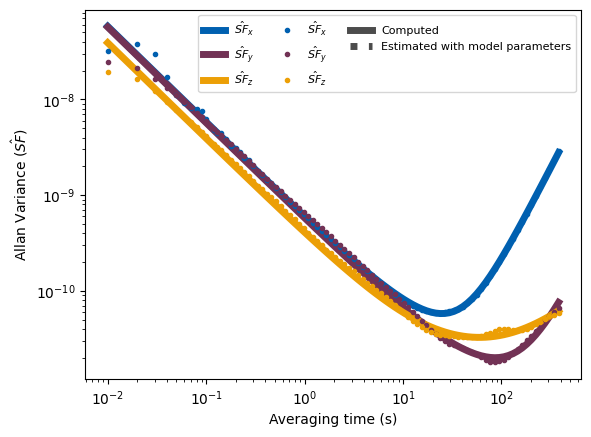

In [76]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(omega_V_hist[:,0], dt)
tau_fy, avar_fy = allan_variance.compute_avar(omega_V_hist[:,1], dt)
tau_fz, avar_fz = allan_variance.compute_avar(omega_V_hist[:,2], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

DISIMU SF hat: quantization    0.00001859746155
white           0.00056087907601
flicker         0.00035507458595
walk            0.00002473881624
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00004832908480
white           0.00075254577298
flicker         0.00034322657580
walk            0.00001303219789
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00000000000000
white           0.00027996896455
flicker         0.00044879991203
walk            0.00000000000000
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

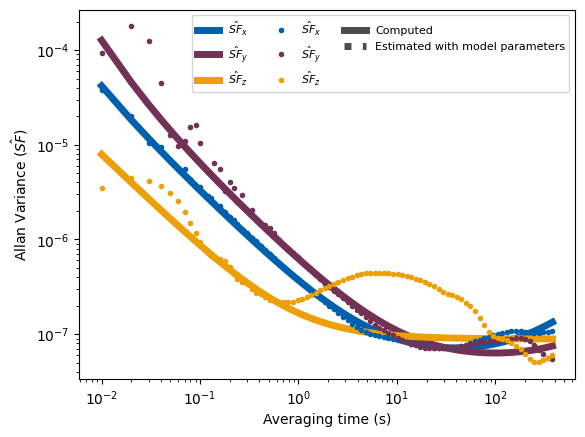

In [77]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(a_V_hist[:,0], dt)
tau_fy, avar_fy = allan_variance.compute_avar(a_V_hist[:,1], dt)
tau_fz, avar_fz = allan_variance.compute_avar(a_V_hist[:,2], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")